# **Phần 1: Code và câu trả lời cho "Thay đổi cấu trúc ANN".**


---



Số mẫu trong X_train: 240
Số mẫu trong y_train: 240
Số mẫu trong X_test: 60
Số mẫu trong y_test: 60


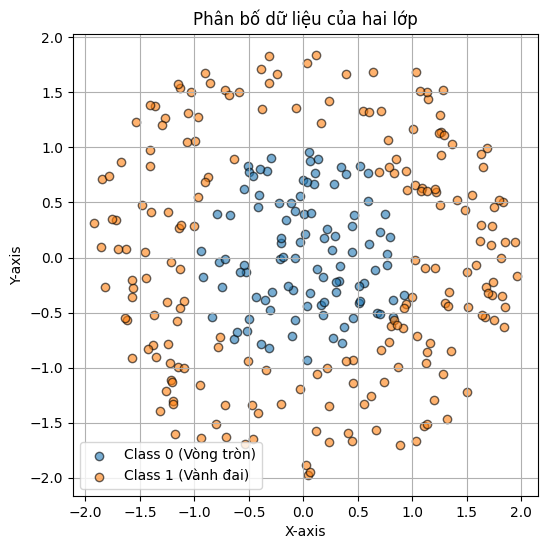

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Đặt seed để kết quả ổn định
torch.manual_seed(42)
np.random.seed(42)

# Tạo điểm cho lớp 0 (vòng tròn)
def generate_class_0(n_samples):
    u = np.random.rand(n_samples)
    theta = np.random.uniform(0, 2 * np.pi, n_samples)
    r = np.sqrt(u)  # Bán kính nhỏ
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

# Tạo điểm cho lớp 1 (vành đai)
def generate_class_1(n_samples):
    u = np.random.rand(n_samples)
    theta = np.random.uniform(0, 2 * np.pi, n_samples)
    r = np.sqrt(3 * u + 1)  # Bán kính lớn hơn
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

# Tạo dữ liệu
X_class0 = generate_class_0(100)
X_class1 = generate_class_1(200)
y_class0 = np.zeros(100)  # Nhãn 0
y_class1 = np.ones(200)   # Nhãn 1

# Kết hợp dữ liệu
X = np.vstack((X_class0, X_class1))
y = np.hstack((y_class0, y_class1))

# Chia dữ liệu với 20% là test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuyển sang tensor PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Thêm chiều cho nhãn
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# In kích thước của từng tập dữ liệu
print("Số mẫu trong X_train:", len(X_train))
print("Số mẫu trong y_train:", len(y_train))
print("Số mẫu trong X_test:", len(X_test))
print("Số mẫu trong y_test:", len(y_test))

# Vẽ dữ liệu phân bố
plt.figure(figsize=(6, 6))
plt.scatter(X_class0[:, 0], X_class0[:, 1], label="Class 0 (Vòng tròn)", alpha=0.6, edgecolors='k')
plt.scatter(X_class1[:, 0], X_class1[:, 1], label="Class 1 (Vành đai)", alpha=0.6, edgecolors='k')

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.title("Phân bố dữ liệu của hai lớp")
plt.grid(True)
plt.show()


**1.1 Mô hình ban đầu (4 nút trong lớp ẩn)**

Epoch [20/100], loss: 0.6049
Epoch [40/100], loss: 0.5641
Epoch [60/100], loss: 0.4728
Epoch [80/100], loss: 0.3899
Epoch [100/100], loss: 0.3316
Độ chính xác của mô hình 4 nút: 83.33%
Mất mát cuối cùng của mô hình 4 nút: 0.3316


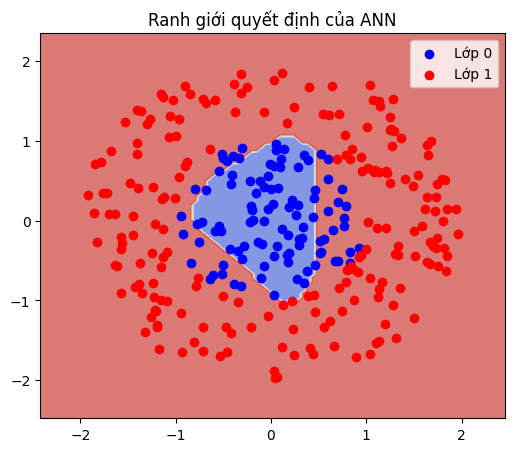

In [ ]:
# Xây dựng mô hình ANN cơ bản (4 nút trong lớp ẩn)
class ANN_4(nn.Module):
    def __init__(self):
        super(ANN_4, self).__init__()
        self.fc1 = nn.Linear(2, 4)  # Đầu vào 2, ẩn 4
        self.relu = nn.ReLU()       # Công tắc ReLU
        self.fc2 = nn.Linear(4, 1)  # Ẩn 4, đầu ra 1
        self.sigmoid = nn.Sigmoid() # Xác suất 0-1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Khởi tạo mô hình
model_4 = ANN_4()

# Định nghĩa mất mát và tối ưu hóa
criterion = nn.BCELoss()          # Hàm mất mát
optimizer = optim.Adam(model_4.parameters(), lr=0.01)  # Tối ưu hóa Adam

# Khởi tạo danh sách lưu loss
loss_history_4 = []

# Huấn luyện
epochs = 100
for epoch in range(epochs):
    model_4.train()
    optimizer.zero_grad()  # Xóa gradient cũ
    outputs = model_4(X_train)  # Dự đoán
    loss = criterion(outputs, y_train)  # Tính sai lầm
    loss.backward()  # Tìm cách sửa
    optimizer.step()  # Sửa trọng số

    # Lưu giá trị loss
    loss_history_4.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], loss: {loss.item():.4f}")

# Kiểm tra
model_4.eval()
with torch.no_grad():
    y_pred = model_4(X_test)  # Dự đoán trên tập kiểm tra
    y_pred = (y_pred >= 0.5).float()  # Chuyển thành 0 hoặc 1
    accuracy_4 = (y_pred == y_test).sum().item() / y_test.size(0)  # Tính độ chính xác
    print(f"Độ chính xác của mô hình 4 nút: {accuracy_4*100:.2f}%")
    print(f"Mất mát cuối cùng của mô hình 4 nút: {loss_history_4[-1]:.4f}")

# Tạo lưới điểm để vẽ ranh giới
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Chuyển lưới thành tensor để dự đoán
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

# Dự đoán trên lưới
model_4.eval()
with torch.no_grad():
    pred_grid = model_4(grid)
    pred_grid = (pred_grid >= 0.5).float().numpy().reshape(xx.shape)

# Vẽ biểu đồ
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, pred_grid, alpha=0.7, cmap='coolwarm')  # Ranh giới quyết định
plt.scatter(X[y.flatten() == 0, 0], X[y.flatten() == 0, 1], color='blue', label='Lớp 0')
plt.scatter(X[y.flatten() == 1, 0], X[y.flatten() == 1, 1], color='red', label='Lớp 1')
plt.legend()
plt.title("Ranh giới quyết định của ANN")
plt.show()

**1.2 Tăng số nút trong lớp ẩn (8 nút)**

Epoch [20/100], loss: 0.5602
Epoch [40/100], loss: 0.5090
Epoch [60/100], loss: 0.4406
Epoch [80/100], loss: 0.3542
Epoch [100/100], loss: 0.2784
Độ chính xác của mô hình 8 nút: 88.33%
Mất mát cuối cùng của mô hình 8 nút: 0.2784


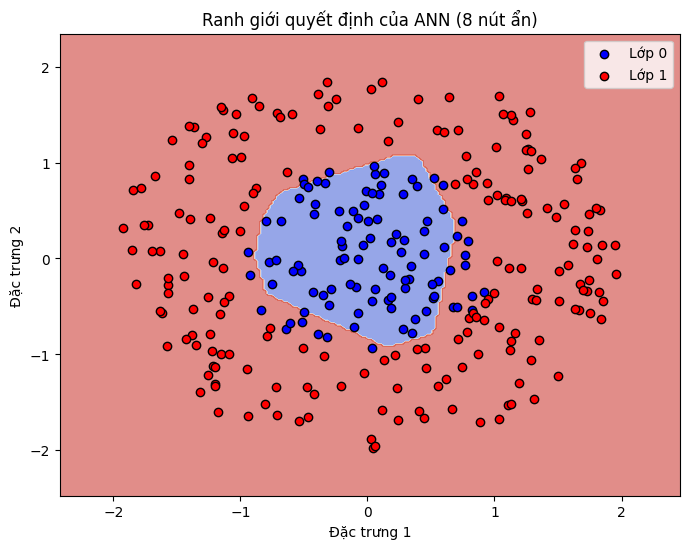

In [ ]:
# Xây dựng mô hình ANN với 8 nút trong lớp ẩn
class ANN_8(nn.Module):
    def __init__(self):
        super(ANN_8, self).__init__()
        self.fc1 = nn.Linear(2, 8)  # Đầu vào 2, ẩn 8
        self.relu = nn.ReLU()       # Công tắc ReLU
        self.fc2 = nn.Linear(8, 1)  # Ẩn 8, đầu ra 1
        self.sigmoid = nn.Sigmoid() # Xác suất 0-1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Khởi tạo mô hình
model_8 = ANN_8()

# Định nghĩa mất mát và tối ưu hóa
criterion = nn.BCELoss()          # Hàm mất mát
optimizer = optim.Adam(model_8.parameters(), lr=0.01)  # Tối ưu hóa Adam

# Khởi tạo danh sách lưu loss
loss_history_8 = []

# Huấn luyện
epochs = 100
for epoch in range(epochs):
    model_8.train()
    optimizer.zero_grad()  # Xóa gradient cũ
    outputs = model_8(X_train)  # Dự đoán
    loss = criterion(outputs, y_train)  # Tính sai lầm
    loss.backward()  # Tìm cách sửa
    optimizer.step()  # Sửa trọng số

    # Lưu giá trị loss
    loss_history_8.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], loss: {loss.item():.4f}")

# Kiểm tra
model_8.eval()
with torch.no_grad():
    y_pred = model_8(X_test)  # Dự đoán trên tập kiểm tra
    y_pred = (y_pred >= 0.5).float()  # Chuyển thành 0 hoặc 1
    accuracy_8 = (y_pred == y_test).sum().item() / y_test.size(0)  # Tính độ chính xác
    print(f"Độ chính xác của mô hình 8 nút: {accuracy_8*100:.2f}%")
    print(f"Mất mát cuối cùng của mô hình 8 nút: {loss_history_8[-1]:.4f}")

# Tạo lưới điểm để vẽ ranh giới
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Chuyển lưới thành tensor để dự đoán
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

# Dự đoán trên lưới với model 8
model_8.eval()
with torch.no_grad():
    pred_grid = model_8(grid).cpu().numpy()
    pred_grid = (pred_grid >= 0.5).astype(int).reshape(xx.shape)

# Vẽ biểu đồ với ranh giới quyết định
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_grid, alpha=0.6, cmap='coolwarm')  # Màu nền theo mô hình phân loại
plt.scatter(X[y.flatten() == 0, 0], X[y.flatten() == 0, 1], color='blue', edgecolors='k', label='Lớp 0')
plt.scatter(X[y.flatten() == 1, 0], X[y.flatten() == 1, 1], color='red', edgecolors='k', label='Lớp 1')

# Hiển thị tiêu đề và chú thích
plt.title("Ranh giới quyết định của ANN (8 nút ẩn)", fontsize=12)
plt.xlabel("Đặc trưng 1", fontsize=10)
plt.ylabel("Đặc trưng 2", fontsize=10)
plt.legend()
plt.show()

**1.3 Thêm một lớp ẩn (8-6 nút)**

Epoch [20/100], loss: 0.6278
Epoch [40/100], loss: 0.5873
Epoch [60/100], loss: 0.5149
Epoch [80/100], loss: 0.4324
Epoch [100/100], loss: 0.3357
Độ chính xác của mô hình 8-6 nút: 78.33%
Mất mát cuối cùng của mô hình 8-6 nút: 0.3357


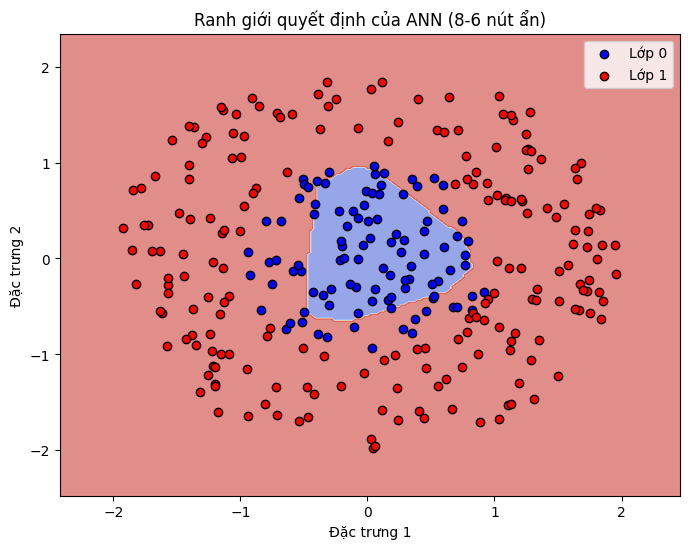

In [ ]:
# Xây dựng mô hình ANN với hai lớp ẩn (8-6 nút)
class ANN_8_6(nn.Module):
    def __init__(self):
        super(ANN_8_6, self).__init__()
        self.fc1 = nn.Linear(2, 8)  # Đầu vào 2, ẩn 8
        self.relu1 = nn.ReLU()      # Công tắc ReLU
        self.fc2 = nn.Linear(8, 6)  # Ẩn 8, ẩn 6
        self.relu2 = nn.ReLU()      # Công tắc ReLU
        self.fc3 = nn.Linear(6, 1)  # Ẩn 6, đầu ra 1
        self.sigmoid = nn.Sigmoid() # Xác suất 0-1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Khởi tạo mô hình
model_8_6 = ANN_8_6()

# Định nghĩa mất mát và tối ưu hóa
criterion = nn.BCELoss()          # Hàm mất mát
optimizer = optim.Adam(model_8_6.parameters(), lr=0.01)  # Tối ưu hóa Adam

# Khởi tạo danh sách lưu loss
loss_history_8_6 = []

# Huấn luyện
epochs = 100
for epoch in range(epochs):
    model_8_6.train()
    optimizer.zero_grad()  # Xóa gradient cũ
    outputs = model_8_6(X_train)  # Dự đoán
    loss = criterion(outputs, y_train)  # Tính sai lầm
    loss.backward()  # Tìm cách sửa
    optimizer.step()  # Sửa trọng số

    # Lưu giá trị loss
    loss_history_8_6.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], loss: {loss.item():.4f}")

# Kiểm tra
model_8_6.eval()
with torch.no_grad():
    y_pred = model_8_6(X_test)  # Dự đoán trên tập kiểm tra
    y_pred = (y_pred >= 0.5).float()  # Chuyển thành 0 hoặc 1
    accuracy_8_6 = (y_pred == y_test).sum().item() / y_test.size(0)  # Tính độ chính xác
    print(f"Độ chính xác của mô hình 8-6 nút: {accuracy_8_6*100:.2f}%")
    print(f"Mất mát cuối cùng của mô hình 8-6 nút: {loss_history_8_6[-1]:.4f}")

# Tạo lưới điểm để vẽ ranh giới
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Chuyển lưới thành tensor để dự đoán
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

# Dự đoán trên lưới với model 8-6
model_8_6.eval()
with torch.no_grad():
    pred_grid = model_8_6(grid).cpu().numpy()
    pred_grid = (pred_grid >= 0.5).astype(int).reshape(xx.shape)

# Vẽ biểu đồ với ranh giới quyết định
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_grid, alpha=0.6, cmap='coolwarm')  # Màu nền theo mô hình phân loại
plt.scatter(X[y.flatten() == 0, 0], X[y.flatten() == 0, 1], color='blue', edgecolors='k', label='Lớp 0')
plt.scatter(X[y.flatten() == 1, 0], X[y.flatten() == 1, 1], color='red', edgecolors='k', label='Lớp 1')

# Hiển thị tiêu đề và chú thích
plt.title("Ranh giới quyết định của ANN (8-6 nút ẩn)", fontsize=12)
plt.xlabel("Đặc trưng 1", fontsize=10)
plt.ylabel("Đặc trưng 2", fontsize=10)
plt.legend()
plt.show()

# So sánh kết quả của 3 mô hình ANN

## KẾT QUẢ

Huấn luyện 3 mô hình mạng nơ-ron nhân tạo (ANN) khác nhau trên cùng một tập dữ liệu phân loại nhị phân:

1. **ANN_4**: 1 lớp ẩn với 4 nút.
2. **ANN_8**: 1 lớp ẩn với 8 nút.
3. **ANN_8_6**: 2 lớp ẩn, lớp đầu 8 nút, lớp sau 6 nút.

Bảng tóm tắt **độ chính xác** (trên tập kiểm tra) và **mất mát cuối cùng** (loss) của mỗi mô hình:

| **Mô hình** | **Cấu trúc lớp ẩn** | **Độ chính xác (%)** | **Mất mát cuối cùng** |
|-------------|---------------------|----------------------|-----------------------|
| **ANN_4**   | 4 nút (1 lớp ẩn)    | 83.33%               | 0.3316               |
| **ANN_8**   | 8 nút (1 lớp ẩn)    | 88.33%               | 0.2784               |
| **ANN_8_6** | 8 nút + 6 nút       | 78.33%               | 0.3357               |

## NHẬN XÉT

1. **Mô hình ANN_4**  
   - Sử dụng một lớp ẩn với 4 nút (4 neurons).  
   - Độ chính xác trên tập kiểm tra là **83.33%**, với giá trị mất mát cuối cùng là **0.3316**.  
   - Ranh giới quyết định (decision boundary) nhìn chung đã phân tách được dữ liệu nhưng vẫn còn một số điểm bị dự đoán sai ở viền.

2. **Mô hình ANN_8**  
   - Sử dụng một lớp ẩn với 8 nút.  
   - Đạt **độ chính xác cao nhất** trong 3 mô hình, **88.33%**, và mất mát cuối cùng thấp hơn (0.2784).  
   - Ranh giới quyết định rõ ràng hơn so với mô hình 4 nút, cho thấy việc tăng số lượng neuron ẩn (với cùng số lớp) đã giúp mô hình học được nhiều biểu diễn phức tạp hơn.

3. **Mô hình ANN_8_6**  
   - Sử dụng hai lớp ẩn, lớp thứ nhất 8 nút và lớp thứ hai 6 nút.  
   - Mặc dù có nhiều tham số hơn, mô hình này cho kết quả **78.33%** - thấp hơn cả hai mô hình còn lại.  
   - Mất mát cuối cùng là **0.3357**, cao hơn so với mô hình ANN_8.  
   - Khả năng lý giải: có thể mô hình này cần nhiều thời gian huấn luyện hơn, hoặc cần tinh chỉnh siêu tham số (như tốc độ học - learning rate, số epoch, batch size) để đạt được hiệu quả cao nhất. Việc nhiều lớp ẩn hơn chưa chắc đã tốt hơn nếu không được tối ưu phù hợp.

## KẾT LUẬN
- **ANN_8** cho hiệu suất tốt nhất với độ chính xác 88.33%.  
- **ANN_4** đứng thứ hai (83.33%), mặc dù có ít nút ẩn hơn nhưng vẫn đạt kết quả tương đối cao.  
- **ANN_8_6** cho kết quả thấp nhất (78.33%), nhưng hoàn toàn có thể cải thiện nếu tinh chỉnh thêm.

VẤN ĐỀ CẦN ĐƯỢC CẢI THIỆN ĐỐI VỚI MÔ HÌNH PHỤ THUỘC VÀO:
- **Dữ liệu** (số lượng mẫu, độ phức tạp của phân phối dữ liệu).  
- **Tài nguyên tính toán** (số lượng tham số, thời gian huấn luyện).  
- **Kỹ thuật tối ưu và siêu tham số** (learning rate, số epoch, hàm kích hoạt, regularization, v.v.).
- Nên thử nghiệm thêm nhiều kiến trúc mô hình và kết hợp với kỹ thuật điều chỉnh siêu tham số (như Grid Search, Random Search hoặc Bayesian Optimization) để tìm được mô hình có hiệu năng tốt và ổn định nhất.


# **Phần 2: Code và câu trả lời cho "Thử nghiệm với hàm mất mát và tối ưu hóa".**

**2.1 Dùng BCEWithLogitsLoss thay cho BCELoss**

In [ ]:
# Xây dựng mô hình ANN không có Sigmoid (cho BCEWithLogitsLoss)
class ANN_BCEWithLogits(nn.Module):
    def __init__(self):
        super(ANN_BCEWithLogits, self).__init__()
        self.fc1 = nn.Linear(2, 4)  # Đầu vào 2, ẩn 4
        self.relu = nn.ReLU()       # Công tắc ReLU
        self.fc2 = nn.Linear(4, 1)  # Ẩn 4, đầu ra 1
        # Không dùng sigmoid ở đây vì BCEWithLogitsLoss tự xử lý

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Khởi tạo mô hình
model_logits = ANN_BCEWithLogits()

# Định nghĩa mất mát và tối ưu hóa
criterion_logits = nn.BCEWithLogitsLoss()  # Hàm mất mát mới
optimizer_logits = optim.Adam(model_logits.parameters(), lr=0.01)  # Tối ưu hóa Adam

# Khởi tạo danh sách lưu loss
loss_history_logits = []

# Huấn luyện
epochs = 100
for epoch in range(epochs):
    model_logits.train()
    optimizer_logits.zero_grad()  # Xóa gradient cũ
    outputs = model_logits(X_train)  # Dự đoán
    loss = criterion_logits(outputs, y_train)  # Tính sai lầm
    loss.backward()  # Tìm cách sửa
    optimizer_logits.step()  # Sửa trọng số

    # Lưu giá trị loss
    loss_history_logits.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], loss: {loss.item():.4f}")

# Kiểm tra
model_logits.eval()
with torch.no_grad():
    y_pred_logits = torch.sigmoid(model_logits(X_test))  # Chuyển logits thành xác suất
    y_pred_logits = (y_pred_logits >= 0.5).float()  # Chuyển thành 0 hoặc 1
    accuracy_logits = (y_pred_logits == y_test).sum().item() / y_test.size(0)  # Tính độ chính xác
    print(f"Độ chính xác của mô hình BCEWithLogitsLoss: {accuracy_logits*100:.2f}%")
    print(f"Mất mát cuối cùng của mô hình BCEWithLogitsLoss: {loss_history_logits[-1]:.4f}")

Epoch [20/100], loss: 0.6067
Epoch [40/100], loss: 0.5683
Epoch [60/100], loss: 0.5309
Epoch [80/100], loss: 0.4752
Epoch [100/100], loss: 0.4031
Độ chính xác của mô hình BCEWithLogitsLoss: 78.33%
Mất mát cuối cùng của mô hình BCEWithLogitsLoss: 0.4031


**2.2 Dùng SGD thay cho Adam**

In [ ]:
# Xây dựng mô hình ANN cơ bản (giống mô hình ban đầu)
class ANN_SGD(nn.Module):
    def __init__(self):
        super(ANN_SGD, self).__init__()
        self.fc1 = nn.Linear(2, 4)  # Đầu vào 2, ẩn 4
        self.relu = nn.ReLU()       # Công tắc ReLU
        self.fc2 = nn.Linear(4, 1)  # Ẩn 4, đầu ra 1
        self.sigmoid = nn.Sigmoid() # Xác suất 0-1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Khởi tạo mô hình
model_sgd = ANN_SGD()

# Định nghĩa mất mát và tối ưu hóa
criterion_sgd = nn.BCELoss()  # Hàm mất mát
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)  # Tối ưu hóa SGD

# Khởi tạo danh sách lưu loss
loss_history_sgd = []

# Huấn luyện
epochs = 100
for epoch in range(epochs):
    model_sgd.train()
    optimizer_sgd.zero_grad()  # Xóa gradient cũ
    outputs = model_sgd(X_train)  # Dự đoán
    loss = criterion_sgd(outputs, y_train)  # Tính sai lầm
    loss.backward()  # Tìm cách sửa
    optimizer_sgd.step()  # Sửa trọng số

    # Lưu giá trị loss
    loss_history_sgd.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], loss: {loss.item():.4f}")

# Kiểm tra
model_sgd.eval()
with torch.no_grad():
    y_pred_sgd = model_sgd(X_test)  # Dự đoán trên tập kiểm tra
    y_pred_sgd = (y_pred_sgd >= 0.5).float()  # Chuyển thành 0 hoặc 1
    accuracy_sgd = (y_pred_sgd == y_test).sum().item() / y_test.size(0)  # Tính độ chính xác
    print(f"Độ chính xác của mô hình SGD: {accuracy_sgd*100:.2f}%")
    print(f"Mất mát cuối cùng của mô hình SGD: {loss_history_sgd[-1]:.4f}")

Epoch [20/100], loss: 0.6706
Epoch [40/100], loss: 0.6624
Epoch [60/100], loss: 0.6555
Epoch [80/100], loss: 0.6496
Epoch [100/100], loss: 0.6446
Độ chính xác của mô hình SGD: 63.33%
Mất mát cuối cùng của mô hình SGD: 0.6446


---

# So sánh kết quả với các hàm mất mát và tối ưu hóa khác nhau

## BCEWithLogitsLoss vs BCELoss

### Kết quả:
- **BCELoss (mô hình ban đầu)**: Mất mát 0.3316, độ chính xác 83.33%.
- **BCEWithLogitsLoss**: Mất mát 0.4031, độ chính xác 78.33%.

### Nhận xét:
- **BCELoss** hoạt động tốt hơn BCEWithLogitsLoss trong bài toán này.
- BCEWithLogitsLoss có thể gây ảnh hưởng đến quá trình tối ưu hóa do tích hợp Sigmoid.
- BCELoss phù hợp hơn vì đầu vào đã qua Sigmoid, giúp tối ưu hóa dễ dàng hơn.

## SGD vs Adam

### Kết quả:
- **Sau 100 epoch, mất mát của Adam giảm xuống 0.3316, trong khi SGD chỉ giảm xuống 0.6446**
- *Adam (mô hình ban đầu)*: Mất mát 0.3316, độ chính xác 83.33%.
- **Quan sát giá trị mất mát qua các epochAdam:** 0.6049 → 0.5641 → 0.4728 → 0.3899 → 0.3316 (giảm đáng kể qua mỗi 20 epoch)
- *SGD*: Mất mát 0.6446, độ chính xác 63.33%.
-**Quan sát giá trị mất mát qua các epochSGD:**: 0.6706 → 0.6624 → 0.6555 → 0.6496 → 0.6446 (giảm rất chậm)

## Nhận xét:
1. **BCELoss hoạt động tốt hơn BCEWithLogitsLoss** trong bài toán này.
2. **SGD với lr=0.01 có thể quá chậm cho bài toán này, cần tốc độ học cao hơn hoặc thêm momentum**
3. **Adam sử dụng momentum và RMSprop để cải thiện quá trình tối ưu hóa**






# **Phần 3: Code vẽ đồ thị và câu trả lời cho "Phân tích kết quả".**

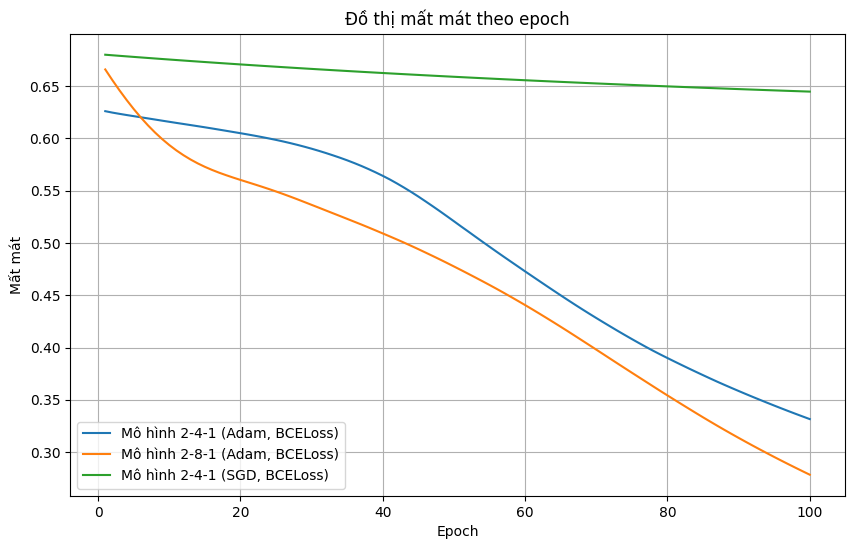

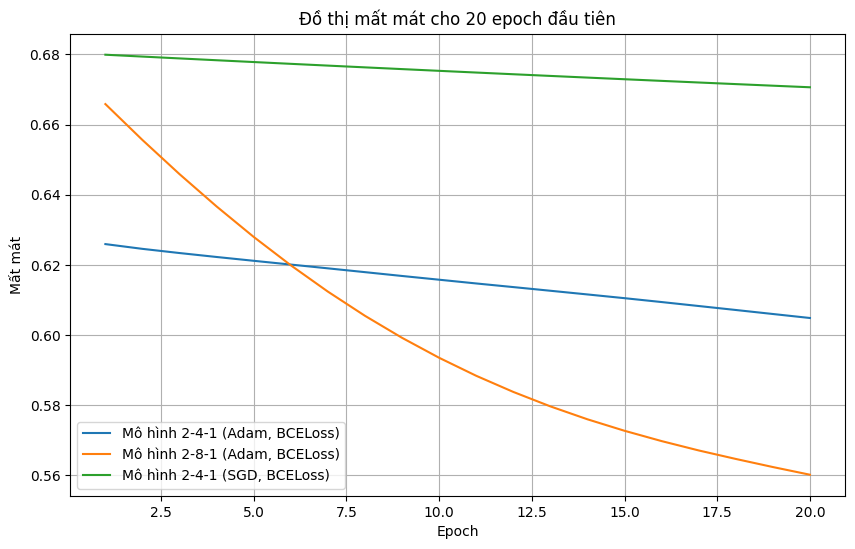

In [ ]:
# Vẽ đồ thị mất mát theo epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history_4, label='Mô hình 2-4-1 (Adam, BCELoss)')
plt.plot(range(1, epochs + 1), loss_history_8, label='Mô hình 2-8-1 (Adam, BCELoss)')
plt.plot(range(1, epochs + 1), loss_history_sgd, label='Mô hình 2-4-1 (SGD, BCELoss)')
plt.xlabel('Epoch')
plt.ylabel('Mất mát')
plt.title('Đồ thị mất mát theo epoch')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ đồ thị mất mát cho 20 epoch đầu tiên
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), loss_history_4[:20], label='Mô hình 2-4-1 (Adam, BCELoss)')
plt.plot(range(1, 21), loss_history_8[:20], label='Mô hình 2-8-1 (Adam, BCELoss)')
plt.plot(range(1, 21), loss_history_sgd[:20], label='Mô hình 2-4-1 (SGD, BCELoss)')
plt.xlabel('Epoch')
plt.ylabel('Mất mát')
plt.title('Đồ thị mất mát cho 20 epoch đầu tiên')
plt.legend()
plt.grid(True)
plt.show()

## Tốc độ giảm mất mát
- **Giảm nhanh nhất:** Mô hình **2-8-1 (Adam, BCELoss)** – đường màu cam. Đây là mô hình có tốc độ giảm mất mát nhanh nhất, đặc biệt trong giai đoạn sau của huấn luyện, với giá trị mất mát đạt khoảng **0.27** ở epoch 100.
- **Giảm chậm nhất:** Mô hình **2-4-1 (SGD, BCELoss)** – đường màu xanh lá. Mất mát chỉ giảm nhẹ từ **0.68 xuống 0.65** sau 100 epoch, cho thấy tốc độ hội tụ rất chậm.

## Sự dao động trong quá trình huấn luyện
Không có mô hình nào thể hiện dao động mạnh, nhưng mô hình **2-4-1 (Adam, BCELoss)** – đường màu xanh dương – có một thay đổi nhẹ trong độ dốc khoảng **epoch 30-50**. Độ giảm mất mát tăng nhanh hơn sau giai đoạn này, có thể do:
- **Adam thích nghi tốt hơn** so với SGD.
- **Cấu trúc mô hình 8 nút có nhiều tham số hơn**, giúp nó học được các mẫu phức tạp hơn.
- **Thay đổi độ dốc do mô hình rơi vào vùng phẳng của không gian mất mát** và sau đó tìm được hướng tối ưu hơn.

Đồ thị thứ hai (20 epoch đầu tiên) cho thấy xu hướng tương tự, trong đó mô hình Adam với 8 nút ẩn giảm mất mát nhanh hơn đáng kể so với các mô hình khác.

## Kết luận:
1. **BCELoss hoạt động tốt hơn BCEWithLogitsLoss** trong bài toán này.
2. **Adam vượt trội hơn SGD** về tốc độ tối ưu hóa và độ chính xác.
3. **Tốc độ giảm mất mát nhanh nhất thuộc về mô hình 2-8-1 (Adam, BCELoss), chậm nhất là 2-4-1 (SGD, BCELoss).**
4. **Không có sự dao động lớn trong mất mát, nhưng một số mô hình có thay đổi độ dốc trong quá trình huấn luyện.**
5. **Việc lựa chọn hàm mất mát, thuật toán tối ưu hóa và cấu trúc mô hình ảnh hưởng lớn đến hiệu suất, cần thử nghiệm nhiều phương pháp để tìm cấu hình tốt nhất.**

